<h1>Проверка гипотез по увеличению выручки в интернет-магазине: оценка результатов A/B теста</h1>

**Описание проекта:** 

Крупный интернет-магазин. Отдел маркетинга подготовил 9 гипотез по увеличению выручки. Каждая гипотеза оценена по параметрам Reach, Impact, Confidence, Effort. Необходимо приоритизировать гипотезы и принять решение по результатам А/В-теста приоритетной гипотезы.

**Задачи:** 
- приоритизировать гипотезы увеличения выручки интернет-магазина;
- оценить результаты А/В-теста приоритетной гипотезы;
- принять решение по результатам А/В-теста.

**Данные:**

Гипотезы:
- описание гипотезы;
- характеристика Reach (оценка масштаба охвата пользователей по 10-балльной шкале);
- характеристика Impact (степень влияния на пользовательский опыт по 10-балльной шкале);
- характеристика Confidence (коэффициент уверенности в истинности гипотезы по 10-балльной шкале);
- характеристика Efforts (оценка предполагаемых затрат ресурсов на проверку гипотезы по 10-балльной шкале).

Заказы:
- уникальный идентификатор пользователя;
- уникальный идентификатор заказа;
- дата совершения заказа;
- сумма заказа;
- группа А/В-теста, в которой состоит пользователь, совершивший заказ.

Пользователи:
- дата;
- группа А/В-теста;
- количество пользователей данной группы на данную дату.



**Содержание проекта:**

[Импорт библиотек и начальные настройки](#step1)  
1. [Часть 1. Приоритизация гипотез](#step2)  
2. [Часть 2. Анализ А/В-теста](#step3)  
  - [2.1. Предобработка данных](#step4)
  - [2.2. Анализ кумулятивных данных по группам теста](#step5) 
  - [2.3. Определение аномальных пользователей и заказов](#step6) 
  - [2.4. Проверка результатов А/В-теста по "сырым" данным](#step7) 
  - [2.5. Проверка результатов А/В-теста по "очищенным" данным](#step8) 
3. [Общие выводы и рекомендации](#step9)

<h2>Импорт библиотек и начальные настройки<a id=step1></a></h2>

Импортируем необходимые для проекта библиотеки:

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

Зададим общий стиль для отрисовки диаграмм в проекте:

In [2]:
plt.style.use('seaborn-darkgrid')

Для удобства управления дальнейшей отрисовкой диаграмм в проекте создадим соответствующие функции.

In [3]:
def set_names(title, xlabel, ylabel):
    '''
    Функция устанавливает названия диаграммы и осей.
    '''
    plt.title(title, fontsize=22)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)

In [4]:
def get_hist(data, column, title, xlabel, ylabel, x_min, x_max, bins=10, figwidth=15, figheight=5):
    '''
    Функция отрисовывает гистограмму.
    На вход получает следующие параметры:
    data - датафрейм;
    column - название колонки датафрейма ('str');
    title - название гистограммы ('str');
    xlabel и ylabel - названия осей гистограммы ('str');
    x_min и x_max - минимальное и максимальное значения оси Х ('int' или 'float')
    bins - количество бинов ('int') - по умолчанию 10;
    figwidth - ширина гистограммы ('int') - по умолчанию 15; 
    figheight - высота гистограммы ('int') - по умолчанию 5.
    '''
    plt.figure(figsize=(figwidth, figheight))
    data[column].hist(bins=bins, range=(x_min, x_max))
    set_names(title, xlabel, ylabel)
    plt.show()


In [5]:
def get_boxplot(data, column, title, xlabel, ylabel, ax_max, figwidth=15, figheight=5, orient=0):
    '''
    Функция отрисовывает диаграмму "ящик с усами".
    На вход получает следующие параметры:
    data - датафрейм;
    column - название колонки датафрейма ('str');
    title - название гистограммы ('str');
    xlabel и ylabel - названия осей гистограммы ('str');
    ax_max - максимальное значения оси распределения.
    orient - ориентация диаграммы (orient='h', если хотим горизонтальный боксплот) - по умолчанию 0, 
    figwidth - ширина диаграммы ('int') - по умолчанию 15; 
    figheight - высота диаграммы ('int') - по умолчанию 5.
    '''
    plt.figure(figsize=(figwidth, figheight))
        
    if orient=='h':
        sns.boxplot(data=data, x=column, orient='h')
        plt.xlim(0, ax_max)
    else:
        sns.boxplot(data=data, y=column)
        plt.ylim(0, ax_max)
            
    set_names(title, xlabel, ylabel)
    plt.show()

In [6]:
def get_line_plot(x_series, y_series, title, xlabel, ylabel, figwidth=15, figheight=5, axis_limits=[], axhline_values=[],
                additional_x_series=pd.Series(dtype='float'), additional_y_series=pd.Series(dtype='float'), labels=[]):
    '''
    Функция отрисовывает линейную диаграмму plot для одного/двух графиков 
    (с возможностью добавления дополнительных горизонтальных осей).
    Функция принимает следующие параметры:
    x_series, y_series - объекты Series для осей X и Y;
    title - название гистограммы ('str');
    xlabel и ylabel - названия осей гистограммы ('str');
    figwidth - ширина диаграммы ('int') - по умолчанию 15; 
    figheight - высота диаграммы ('int') - по умолчанию 5.
    axis_limits - список крайних координат для осей [x_min, x_max, y_min, y_max] ('int' или 'float') - по умолчанию [];
    axhline_value - координаты дополнительных горизонтальных осей (не больше 4-х) ('int' или 'float') - по умолчанию [];
    additional_x_series, additional_y_series - объекты Series для осей X и Y второго графика (если он нужен);
    labels - список названий графиков для легенды [label_1, label_2] ('str') - по умолчанию [].
    '''
    plt.figure(figsize=(figwidth, figheight))
        
    # Если получены значения для дополнительного графика, то строим оба графика:
    if len(additional_y_series)>0:
        plt.plot(x_series, y_series, label=labels[0])
        plt.plot(additional_x_series, additional_y_series, label=labels[1])
        plt.legend() # Показываем легенду

    else:
        plt.plot(x_series, y_series)
            
    set_names(title, xlabel, ylabel)  # Указываем названия диаграммы и осей

    # Если заданы лимиты для осей, то учитываем их:
    if axis_limits!=[]:
        plt.axis(axis_limits)
            
    axhline_colors = ['black', 'grey', 'blue', 'red']  # Цвета дополнительных горизонтальных осей
        
    # Если координаты дополнительных горизонтальных осей присутствуют, отрисовываем их:
    if len(axhline_values)!=0:  
            
        for i in range(0, len(axhline_values)):
            plt.axhline(y=axhline_values[i], color=axhline_colors[i], linestyle='--') 
        
    plt.show()

In [7]:
def get_scatter_plot(x_series, y_series, title, xlabel, ylabel, figwidth=15, figheight=5, axis_limits=[]):
    '''
    Функция отрисовывает точечную диаграмму.
    Функция принимает следующие параметры:
    x_series, y_series - объекты Series для осей X и Y;
    title - название гистограммы ('str');
    xlabel и ylabel - названия осей гистограммы ('str');
    figwidth - ширина диаграммы ('int') - по умолчанию 15; 
    figheight - высота диаграммы ('int') - по умолчанию 5.
    axis_limits - список крайних координат для осей [x_min, x_max, y_min, y_max] ('int' или 'float') - по умолчанию [].
    '''
    plt.figure(figsize=(figwidth, figheight))
    plt.scatter(x_series, y_series)
    set_names(title, xlabel, ylabel)
        
    # Если заданы лимиты для осей, то учитываем их:
    if axis_limits!=[]:
        plt.axis(axis_limits)
            
    plt.show()

Создадим функцию для проверки статистических гипотез критерием Манна-Уитни:

In [8]:
def check_hypothesis(alpha, sample_A, sample_B):
    '''
    Функция проверяет статистическое различие средних значений выборок sample_A и sample_В
    с применением непараметрического критерия Манна-Уитни и заданным критическим уровнем 
    статистической значимости alpha.
    '''
    p_value = stats.mannwhitneyu(sample_A, sample_B)[1]  # Рассчитываем p-value,
    print('P-value равно: {0:.3f}'.format(p_value))      # выводим его на экран
    
    # Сравниваем p-value с критическим уровнем значимости, и выводим результат на экран:
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между средними есть значимая разница')
    
    else:
        print('Отвергнуть нулевую гипотезу не получилось: между средними нет значимой разницы')

<h2>Часть 1. Приоритизация гипотез<a id=step2></a></h2>

Изучим файл с гипотезами:

In [9]:
hypothesis = pd.read_csv('datasets/hypothesis.csv', sep=",")
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Приведём названия столбцов в нижний регистр:

In [10]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Для приоритизации гипотез воспользуемся показателем ICE, который представляет собой синтетический коэффициент, рассчитанный из трёх показателей: Impact, Confidence и Efforts. Мы перемножаем оценки влияния гипотезы на пользователей и уверенности в правдивости данной гипотезы. Затем полученное произведение делим на оценку вероятных затрат, которые необходимы для проверки данной гипотезы. Рассчитаем показатель ICE в отдельном столбце:

In [11]:
hypothesis['ICE'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(1)

Отсортируем гипотезы по убыванию значений ICE:

In [12]:
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.2
0,"Добавить два новых канала привлечения трафика,...",13.3
7,Добавить форму подписки на все основные страни...,11.2
6,Показать на главной странице баннеры с актуаль...,8.0
2,Добавить блоки рекомендаций товаров на сайт ин...,7.0
1,"Запустить собственную службу доставки, что сок...",2.0
5,"Добавить страницу отзывов клиентов о магазине,...",1.3
3,"Изменить структура категорий, что увеличит кон...",1.1
4,"Изменить цвет фона главной страницы, чтобы уве...",1.0


Если не учитывать охвата пользователей (показатель Reach), то самыми приоритетными являются гипотезы №8, №0 и №7. Синтетический показатель ICE говорит, главным образом, о степени влияния гипотезы на пользовательский опыт, при прочих равных.

Успех или неуспех любого продукта зависит от мнения о нем его потребителей. Чем больше потребителей у продукта, тем радикальнее он зависит от оценок большинства. Любое изменение в продукте способно изменить это мнение, что скажется на продажах. Поэтому в процессе приоритизации гипотез необходимо учитывать масштаб охвата пользователей, которых затронет данная гипотеза. Рассчитаем показатель RICE, учитывающий коэффициент Reach, в отдельном столбце:

In [13]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

Отсортируем гипотезы по убыванию значений RICE:

In [14]:
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


**Выводы по части 1:**

Если, кроме силы влияния на пользователей, учитывать и широту охвата пользователей, то лидируют гипотезы №7, №2 и №0. Гипотеза №8, лидировавшая во фреймворке ICE, с учётом охвата пользователей выбыла из числа приоритетных. Гипотеза №7 является самой приоритетной из-за параметра 'reach', который является самым высоким среди конкурентов, при относительно высоких показателях влияния на пользователя (impact), уверенности в выставленных оценках (confidence), а также среднем показателе требуемых для проверки усилий (efforts).

<h2>Часть 2. Анализ А/В-теста<a id=step3></a></h2>

Для анализа представлены результаты проведённого А/В-тестирования одной из приоритетных гипотез.

<h3>2.1. Предобработка данных<a id = step4></a></h3>

Изучим файл с результатами A/B-теста:

In [15]:
orders = pd.read_csv('datasets/orders.csv', sep=",")
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [17]:
orders.group.unique()

array(['B', 'A'], dtype=object)

In [18]:
visitors = pd.read_csv('datasets/visitors.csv', sep=",")
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [19]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [20]:
visitors.group.unique()

array(['A', 'B'], dtype=object)

Датафреймы visitors и orders не содержат пропусков. Строковые значения в столбцах 'group' обоих датафреймов содержат по два значения 'A' и 'B'. 

Названия столбцов в orders необходимо привести к единому стилю. Сделаем это:

In [21]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Даты необходимо привести к формату datetime. Сделаем это:

In [22]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Проверим типы данных после преобразований:

In [23]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [24]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Теперь типы данных соответствуют их значениям.

Проверим данные на присутствие дублей:

In [25]:
visitors.duplicated().sum()

0

In [26]:
orders.duplicated().sum()

0

Полные дубликаты в наблюдениях отсутствуют.

Проверим данные на присутствие аномалий:

In [27]:
#Создадим массив с интересующими нас названиями столбцов
df_columns = [visitors.date, orders.date, visitors.visitors, orders.revenue]

In [28]:
for column in df_columns:
    print(column.describe())
    print()

count                      62
unique                     31
top       2019-08-02 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

count     62.000000
mean     607.290323
std      114.400560
min      361.000000
25%      534.000000
50%      624.500000
75%      710.500000
max      770.000000
Name: visitors, dtype: float64

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64



Данные о заказах и посетителях принадлежат отдому временному диапазону с 01.08.2019 по 31.08.2019. Данные о количестве посетителей в день выглядят нормально распределёнными с небольшим смещением влево. Данные о выручке содержат выбросы, т.к. среднее значение в 2,5 раза выше медианы.

Посмотрим распределение выручки на диаграмме (воспользуемся созданным классом CreateChart):

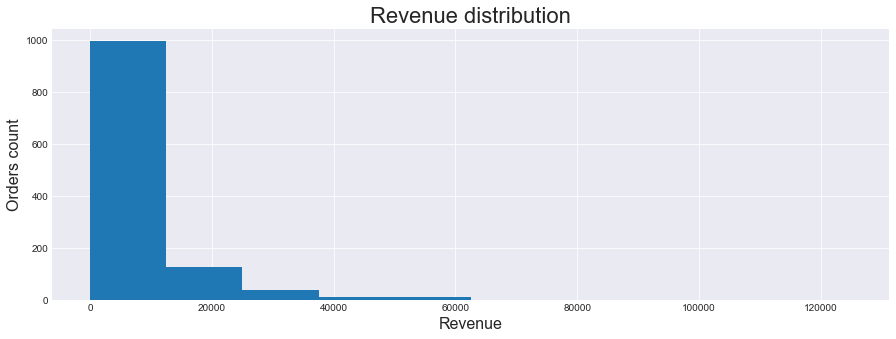

In [29]:
get_hist(data=orders, column='revenue', title='Revenue distribution', 
         xlabel='Revenue', ylabel='Orders count', x_min=0, x_max=125000)

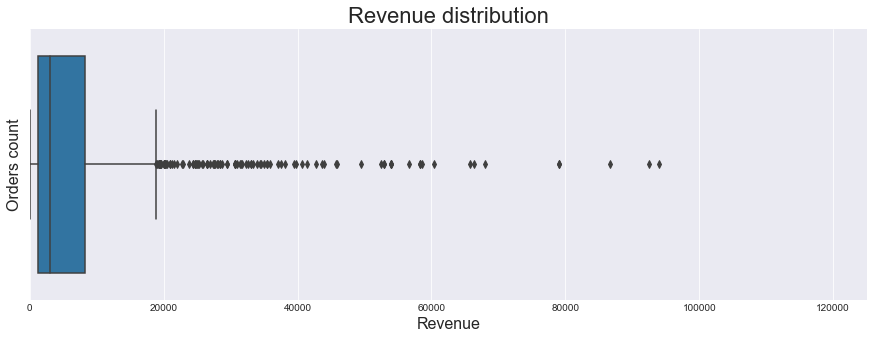

In [30]:
get_boxplot(data=orders, column='revenue', title='Revenue distribution', xlabel='Revenue', ylabel='Orders count', 
            orient='h', ax_max=125000)

Определим количество и долю аномальных значений выручки:

In [31]:
revenue_normal_limit = 50000  #будем считать аномальной выручкой значения, выше этого 

In [32]:
abnormal_revenue_counts = orders.query('revenue>@revenue_normal_limit')['revenue'].count()
abnormal_revenue_counts

21

In [33]:
abnormal_revenue_sum = orders.query('revenue>@revenue_normal_limit')['revenue'].sum()
abnormal_revenue_sum

2740462

In [34]:
abnormal_revenue_counts / orders.revenue.count()

0.017543859649122806

In [35]:
abnormal_revenue_sum / orders.revenue.sum()

0.2742501598438759

Мы имеем 21 значение выручки выше 50000 руб., что составляет 1,8% от общего количества. При этом сумма выручки этих значений составляет 27,4% от общей суммы выручки, что подтверждает сильное искажающее влияние данных значений, на общую статистику по выручке. Запомним этот факт и учтём его в дальнейшем анализе.

<h3>2.2. Анализ кумулятивных данных по группам теста<a id = step5></a></h3>

Для того чтобы избежать "эффекта подглядывания" при проведении А/В-теста (когда значимые отличия в двух выборках достигаются либо на ранних этапах - в связи с "эффектом малой базы", - либо на этапах, когда в выборках появляются аномальные значения), при проверке результатов А/В-теста будем руководствоваться кумулятивными данными, которые нивелируют случайные "всплески".

Вспомним, как выглядит датафрейм orders:

In [36]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Создадим массив уникальных пар значений дат и групп теста:

In [37]:
dates_groups = orders[['date','group']].drop_duplicates()
dates_groups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Получим агрегированные кумулятивные по дням данные о заказах. А именно, пройдём по строкам dates_groups:
- для каждой даты будем брать срез из датафрейма orders, состоящий из строк с более ранними датами и той же группой теста;
- и в этом срезе:
    - ввыведем максимальную дату (она будет равна дате в датафрейме dates_groups);
    - выведем группу теста;
    - посчитаем количество уникальных заказов;
    - посчитаем количество уникальных покупателей;
    - сумму всех заказов; 
- полученный датафрейм отсортируем по дате и группе теста:

In [38]:
orders_aggregated = (dates_groups
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
        .agg({'date' : 'max',   #максимальная дата в orders равна очередной дате в dates_groups
              'group' : 'max',  #здесь просто выводим соответствующую группу теста
              'transaction_id' : 'nunique', #считаем количество уникальных заказов
              'visitor_id' : 'nunique',     #считаем количество уникальных покупателей
              'revenue' : 'sum'}),          #сумма всех заказов за предыдущий период на соответствующую дату
        axis=1)
    .sort_values(by=['date','group'])           #сортируем по дате и группе теста
    )

orders_aggregated.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Датафрейм orders_aggregated содержит кумулятивные данные о количестве заказов и покупателей, а также сумме всех заказов, на определённую дату (за весь предыдущий период) с разбивкой по группам теста.

Вспомним, как выглядит датафрейм visitors:

In [39]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина. А именно, пройдём по строкам dates_groups:
- для каждой даты будем брать срез из датафрейма visitors, состоящий из строк с более ранними датами и той же группой теста;
- и в этом срезе:
    - ввыведем максимальную дату (она будет равна дате в датафрейме dates_groups);
    - выведем группу теста;
    - количество всех посетителей; 
- полученный датафрейм отсортируем по дате и группе теста:

In [40]:
visitors_aggregated = (dates_groups
    .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
        .agg({'date' : 'max',           #максимальная дата в visitors равна очередной дате в dates_groups
              'group' : 'max',          #здесь просто выводим соответствующую группу теста
              'visitors' : 'sum'}),     #считаем количество посетителей за весь период в данном срезе
        axis=1)
    .sort_values(by=['date','group'])   #сортируем по дате и группе теста
)

visitors_aggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Датафрейм visitors_aggregated содержит кумулятивные данные о количестве посетителей, на определённую дату (за весь предыдущий период) с разбивкой по группам теста.

Объединим кумулятивные данные в одной таблице и присвоим ее столбцам понятные названия:

In [41]:
cumulative_data = orders_aggregated.merge(visitors_aggregated, on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Создадим датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням отдельно в группе А и в группе B:

In [42]:
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_A.head()

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


In [43]:
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]
cumulative_revenue_B.head()

,date,revenue,orders
1,2019-08-01,101217,21
3,2019-08-02,266748,45
5,2019-08-03,380996,61
7,2019-08-04,489567,78
9,2019-08-05,581995,101


**График кумулятивной выручки по группам**

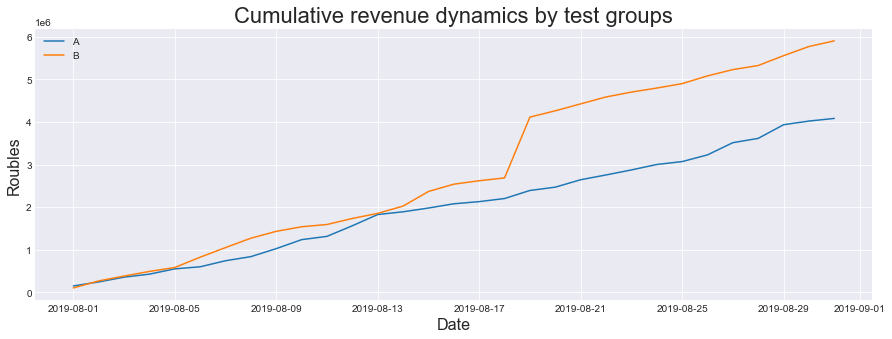

In [44]:
get_line_plot(title='Cumulative revenue dynamics by test groups', xlabel='Date', ylabel='Roubles', 
              x_series=cumulative_revenue_A['date'], 
              y_series=cumulative_revenue_A['revenue'], 
              additional_x_series=cumulative_revenue_B['date'], 
              additional_y_series=cumulative_revenue_B['revenue'],
              labels=['A','B'])

Равномерное увеличение выручки в первой половине тестового периода прерывается резким одномоментным увеличением выручки в группе В, затем продолжается параллельная динамика. Это может говорить либо о резком увеличении числа заказов в группе B, либо об аномальной величине некоторых заказов. Проверим это в дальнейшем анализе.

**График динамики среднего чека по группам**

Чтобы посмотреть график динамики среднего чека необходимо кумулятивную выручку разделить на кумулятивное количество заказов. Сделаем это при построении диаграммы:

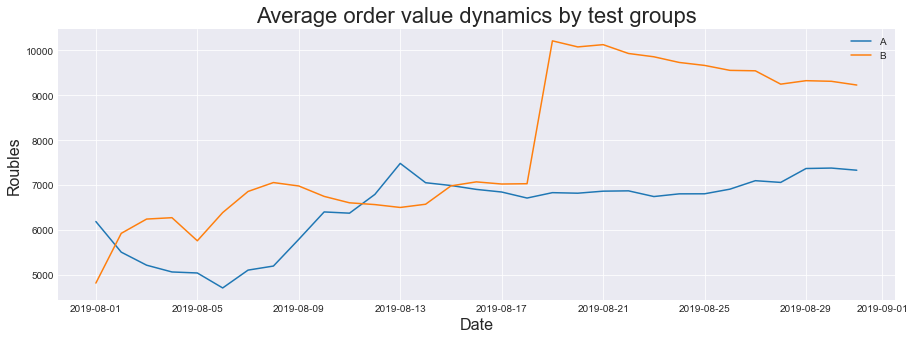

In [45]:
get_line_plot(title='Average order value dynamics by test groups', xlabel='Date', ylabel='Roubles', 
              x_series=cumulative_revenue_A['date'], 
              y_series=cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], 
              additional_x_series=cumulative_revenue_B['date'], 
              additional_y_series=cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], 
              labels=['A','B'])

Во второй половине тестового периода средний чек в группе А стабилизировался. В группе B после резкого увеличения, в середине тестового периода, средний чек постепенно снижается, сглаживая аномальную активность предыдущего периода (крупные заказы отразились всплеском на графике), но ему необходимо ещё время для стабилизации.

**График относительного изменения среднего чека группы B к группе A**

Собираем кумулятивные данные в одном датафрейме:

In [46]:
merged_cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, on='date', how='left', suffixes=['_A', '_B'])
merged_cumulative_revenue.head()

,date,revenue_A,orders_A,revenue_B,orders_B
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


Строим отношение средних чеков и добавляем дополнительную ось Х (визуальный уровень равенства данных в группах А и В):

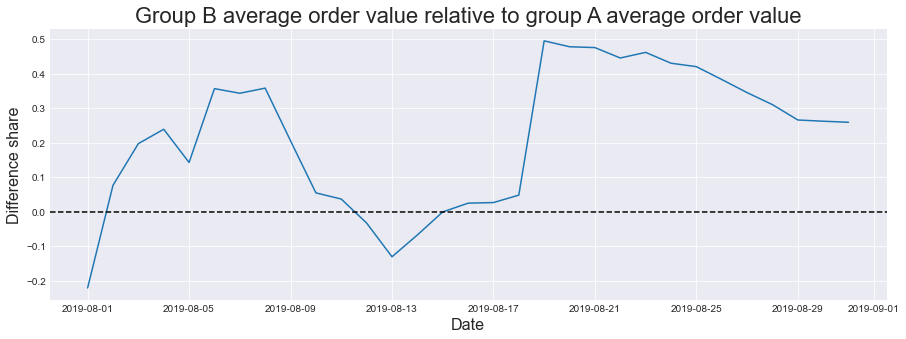

In [47]:
get_line_plot(title='Group B average order value relative to group A average order value', 
              xlabel='Date', ylabel='Difference share', 
              x_series=merged_cumulative_revenue['date'],
              y_series=((merged_cumulative_revenue['revenue_B']/merged_cumulative_revenue['orders_B'])/
                        (merged_cumulative_revenue['revenue_A']/merged_cumulative_revenue['orders_A'])-1),
              axhline_values=[0])

График отражает разницу, на сколько средний чек в группе B отличается от среднего чека в группе А. Он нестабилен. Причинами всплесков могут быть аномально крупные заказы или выбросы в виде аномального количества заказов.

**График кумулятивной конверсии по группам**

Рассчитаем кумулятивную конверсию:

In [48]:
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


Отделим данные по группе A и по группе В:

In [49]:
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

Построим графики, задав масштаб осей:

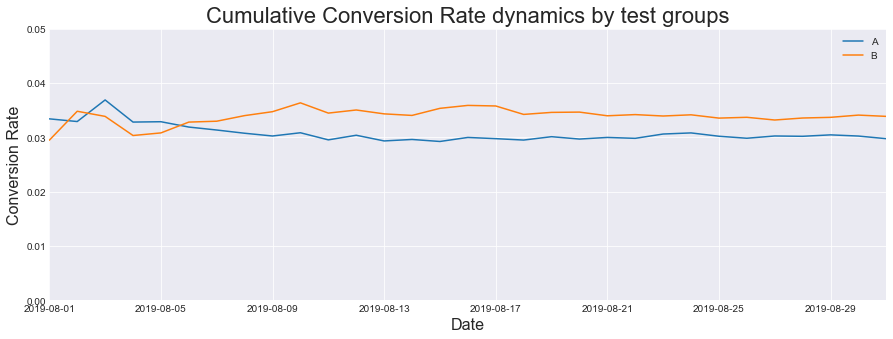

In [50]:
get_line_plot(title='Cumulative Conversion Rate dynamics by test groups', xlabel='Date', ylabel='Conversion Rate', 
              x_series=cumulative_data_A['date'],
              y_series=cumulative_data_A['conversion'],
              additional_x_series=cumulative_data_B['date'],
              additional_y_series=cumulative_data_B['conversion'],
              axis_limits=[pd.to_datetime('2019-08-01'), pd.to_datetime('2019-08-31'), 0, 0.05],
              labels=['A', 'B'])

После колебаний конверсии в группах относительно друг друга в первую неделю теста, конверсия группы В вырвалась вперёд и стабилизировалась, в то время как конверсия группы А просела и также зафиксировалась.

**График относительного изменения кумулятивной конверсии группы B к группе A**

Соединим кумулятивные данные о конверсиях двух групп в одну таблицу:

In [51]:
merged_cumulative_conversions = (cumulative_data_A[['date','conversion']]
    .merge(cumulative_data_B[['date','conversion']], 
        on='date', 
        how='left', 
        suffixes=['_A', '_B'])
    )

merged_cumulative_conversions.head()

,date,conversion_A,conversion_B
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


Посторим график относительного прироста конверсии группы B относительно группы A:

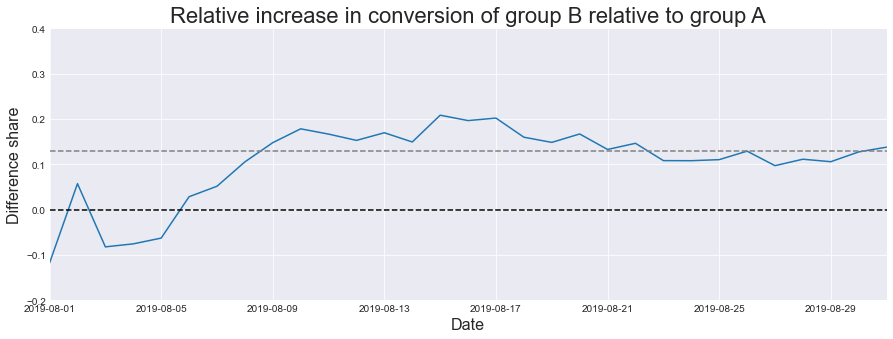

In [52]:
get_line_plot(title='Relative increase in conversion of group B relative to group A', 
              xlabel='Date', ylabel='Difference share', 
              x_series=merged_cumulative_conversions['date'],
              y_series=(merged_cumulative_conversions['conversion_B']/merged_cumulative_conversions['conversion_A']-1),
              axis_limits=[pd.to_datetime('2019-08-01'), pd.to_datetime('2019-08-31'), -0.2, 0.4], 
              axhline_values=[0, 0.13])

Конверсия в группе В в начале теста сделала рывок и превысила конверсию в группе А. Затем она на 4 дня просела ниже конверсии в группе А, чтобы снова увеличится до уровня порядка 20%,превышающего конверсию в группе А. Последние три недели конверсия в группе В пытается стабилизироваться вокруг уровня на 13% выше конверсии в группе А. Однако, пока нельзя с уверенностью сказать, что она стабилизировалась. Выводы делать рано, необходимо проанализировать влияние аномалий.

<h3>2.3. Определение аномальных пользователей и заказов<a id = step6></a></h3>

**Точечный график количества заказов по пользователям**

Аномальные значения сумм или количества заказов, севершаемых тем или иным покупателем, могут сильно исказить общий тренд в конверсии. Для обнаружения аномальных значений далее построим точечные графики и определим границы аномалий (при их наличии)

Определим количество заказов на одного покупателя:

In [53]:
orders_by_buyers = (orders[['visitor_id', 'transaction_id']]
    .groupby('visitor_id', as_index=False)         #Группируем по покупателям
    .agg({'transaction_id' : 'nunique'})   #Считаем уникальные заказы на каждого покупателя
    )

orders_by_buyers.columns = ['buyer_id', 'orders']                    #Понятно называем столбцы
orders_by_buyers.sort_values(by='orders',ascending=False).head(10)     #Сортируем количество заказов по убыванию

,buyer_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Есть небольшое количество покупателей, сделавших в 2 раза больше заказов, чем основная масса покупателей в первой 10-ке самых активных. Это может влиять на статистику средних значений. Изучим количество заказов на одного покупателя на точечной диаграмме. 

Для этого сначала создадим объект Series длиной, равной количеству наблюдений (покупателей) в таблице orders_by_users, значения которого будут координатами по оси Х в будущей диаграмме:

In [54]:
x_values_orders_by_buyers = pd.Series(range(0,len(orders_by_buyers['buyer_id'])))

Отрисуем диаграмму, воспользовавшись созданным классом CreateChart:

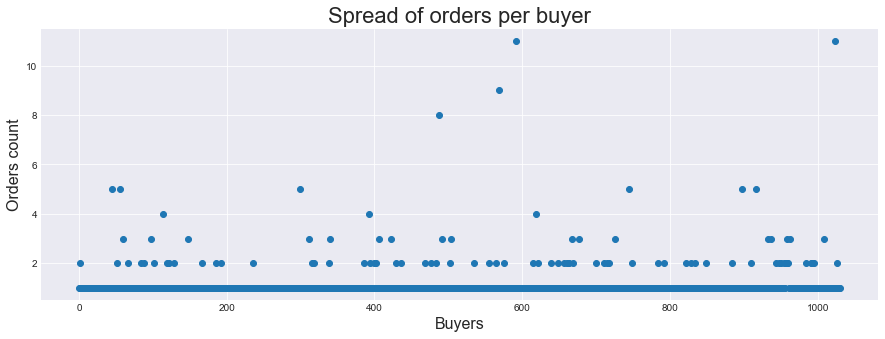

In [55]:
get_scatter_plot(x_series=x_values_orders_by_buyers, y_series=orders_by_buyers['orders'], 
                 title='Spread of orders per buyer', xlabel='Buyers', ylabel='Orders count')

Судя по графику можно предположить, что аномальным количеством покупок на одного покупателя можно считать от 3-х покупок. Однако, принято отсеивать от 1% до 5% крайних значений. Определим эти уровни, рассчитав 95-й и 99-й перцентили количества заказов на одного покупателя.

**Определение границы аномальных пользователей**

Рассчитаем 95-й и 99-й перцентили количества заказов на одного покупателя:

In [56]:
np.percentile(orders_by_buyers['orders'], [95, 99])

array([2., 4.])

Не более 5% покупателей сделали более 2 заказов и только 1% - 4 заказа и более. Будем считать аномальными пользователей с  количеством заказов более двух.

**Tочечный график стоимостей заказов**

Также как и в предыдущем разделе, создадим объект Series длиной, равной количеству заказов в исходной таблице orders:

In [57]:
x_values_orders = pd.Series(range(0,len(orders['revenue'])))

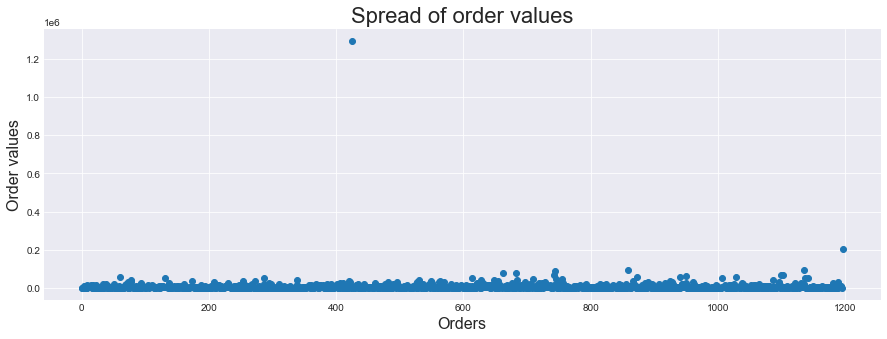

In [58]:
get_scatter_plot(x_series=x_values_orders, y_series=orders['revenue'], 
                 title='Spread of order values', xlabel='Orders', ylabel='Order values')

Очевидно искажающее влияние на статистику двух выбросов с суммами выручки выше 200 тыс. руб. Изучим распределение подробнее, применив более мелкий масштаб:

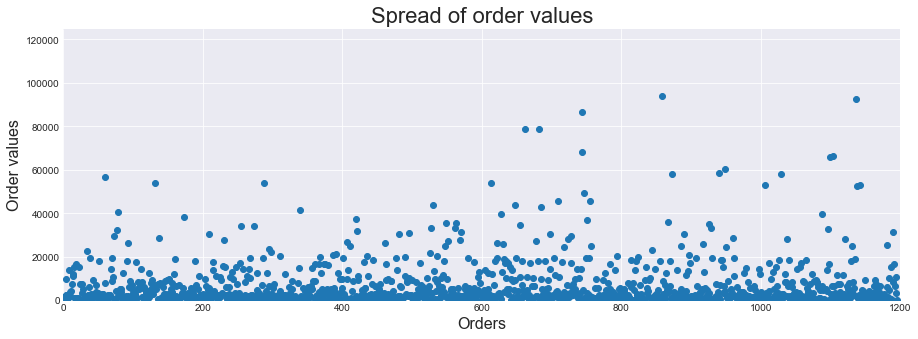

In [59]:
get_scatter_plot(x_series=x_values_orders, y_series=orders['revenue'], 
                 title='Spread of order values', xlabel='Orders', ylabel='Order values', axis_limits=[0, 1200, 0, 125000])

На графике видно, что размер основной массы заказов находится в пределах 60000 рублей. Более дорогие заказы можно принять за аномальные и отсеить. Для более точного определения аномалий рассчитаем 95-й и 99-й перцентили стоимости заказов.

**Определение границы аномальных заказов**

Рассчитаем 95-й и 99-й перцентили стоимости заказов:

In [60]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% заказов стоимостью более 28 000 руб., и 1% заказов стоимостью более 58 233 руб. Будем считать аномальными заказы, стоимостью более 40 000 руб.

<h3>2.4. Проверка результатов А/В-теста по "сырым" данным<a id = step7></a></h3>

**Статистическая значимость различий в конверсии между группами по «сырым» данным**

Для того чтобы определить, есть ли различие в конверсиях двух групп, участвующих в А/В-тестировании, недостаточно просто сравнить их значения. Необходимо определить наличие статистической разницы между этими конверсиями, то есть не получилась ли эта разница случайно. Для такой проверки воспользуемся непараметричским тестом с применением U-критерия Манна-Уитни, который сравнивает средние значения двух выборок и подходит для использования при сравнении выборок, содержащих выбросы. Так мы проверим различие (или его отсутствие) к конверсиях двух групп пользователей по "сырым" данным.

Для начала сведём в единую таблицу все данные о посетителях, количестве и сумме заказов на каждый день для каждой группы теста. 

Приведём названия столбцов в таблице merged_cumulative_revenue в соответствие их действительным значениям (добавим прилагательное cumulative):

In [61]:
merged_cumulative_revenue.columns = ['date', 'revenue_cumulative_A', 'orders_cumulative_A', 
                                     'revenue_cumulative_B', 'orders_cumulative_B']
merged_cumulative_revenue.head()

,date,revenue_cumulative_A,orders_cumulative_A,revenue_cumulative_B,orders_cumulative_B
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


Разделим кумулятивные по дням данные о посетителях по группам теста:

In [62]:
cumulative_visitors_A = cumulative_data[cumulative_data['group']=='A'][['date','visitors']]
cumulative_visitors_A.columns = ['date', 'visitors_comulative_A']  #приведём в соответствие название столбца
cumulative_visitors_A.head()

,date,visitors_comulative_A
0,2019-08-01,719
2,2019-08-02,1338
4,2019-08-03,1845
6,2019-08-04,2562
8,2019-08-05,3318


In [63]:
cumulative_visitors_B = cumulative_data[cumulative_data['group']=='B'][['date','visitors']]
cumulative_visitors_B.columns = ['date', 'visitors_comulative_B']  #приведём в соответствие название столбца
cumulative_visitors_B.head()

,date,visitors_comulative_B
1,2019-08-01,713
3,2019-08-02,1294
5,2019-08-03,1803
7,2019-08-04,2573
9,2019-08-05,3280


Рассчитаем ежедневное абсолютное количество посетителей в группах теста:

In [64]:
visitors_A_daily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']
visitors_A_daily.head()

,date,visitors_per_date_A
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [65]:
visitors_B_daily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']
visitors_B_daily.head()

,date,visitors_per_date_B
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


Рассчитаем ежедневное абсолютное количество и величину заказов в группах теста:

In [66]:
orders_A_daily = (orders[orders['group']=='A'][['date', 'transaction_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id' : 'nunique', 'revenue' : 'sum'})
    )
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']
orders_A_daily.head()

,date,orders_per_date_A,revenue_per_date_A
0,2019-08-01,24,148579
1,2019-08-02,20,93822
2,2019-08-03,24,112473
3,2019-08-04,16,70825
4,2019-08-05,25,124218


In [67]:
orders_B_daily = (orders[orders['group']=='B'][['date', 'transaction_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id' : 'nunique', 'revenue' : 'sum'})
    )
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']
orders_B_daily.head()

,date,orders_per_date_B,revenue_per_date_B
0,2019-08-01,21,101217
1,2019-08-02,24,165531
2,2019-08-03,16,114248
3,2019-08-04,17,108571
4,2019-08-05,23,92428


Объединим все данные в одной таблице:

In [68]:
data = (merged_cumulative_revenue.merge(cumulative_visitors_A, on='date', how='left')
    .merge(cumulative_visitors_B, on='date', how='left')
    .merge(visitors_A_daily, on='date', how='left')
    .merge(visitors_B_daily, on='date', how='left')
    .merge(orders_A_daily, on='date', how='left')
    .merge(orders_B_daily, on='date', how='left')
    )
data.head()

,date,revenue_cumulative_A,orders_cumulative_A,revenue_cumulative_B,orders_cumulative_B,visitors_comulative_A,visitors_comulative_B,visitors_per_date_A,visitors_per_date_B,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B
0,2019-08-01,148579,24,101217,21,719,713,719,713,24,148579,21,101217
1,2019-08-02,242401,44,266748,45,1338,1294,619,581,20,93822,24,165531
2,2019-08-03,354874,68,380996,61,1845,1803,507,509,24,112473,16,114248
3,2019-08-04,425699,84,489567,78,2562,2573,717,770,16,70825,17,108571
4,2019-08-05,549917,109,581995,101,3318,3280,756,707,25,124218,23,92428


Теперь сформируем выборки, состоящие из всех посетителей с указанием количества заказов, которые они сделали. Посетители без заказов будут имет 0 (ноль) заказов.

Создадим переменные orders_by_visitors_A и orders_by_visitors_B со столбцами 'visitor_id' и 'orders'. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [69]:
orders_by_visitors_A = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : 'nunique'})
orders_by_visitors_A.columns = ['visitor_id', 'orders']
orders_by_visitors_A.head()

,visitor_id,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [70]:
orders_by_visitors_B = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : 'nunique'})
orders_by_visitors_B.columns = ['visitor_id', 'orders']
orders_by_visitors_B.head()

,visitor_id,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


Объявим переменные sample_A и sample_B, в которых посетителям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули:

In [71]:
sample_A = pd.concat([orders_by_visitors_A['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_visitors_A['orders'])), name='orders')],
    axis=0)    #Присоединяем строки 

In [72]:
sample_B = pd.concat([orders_by_visitors_B['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_B'].sum() - len(orders_by_visitors_B['orders'])), name='orders')],
    axis=0)  

Получили выборки, где число элементов — это количество пользователей, а сумма всех элементов — количество заказов. Соответственно, среднее значение по выборке будет равно конверсии (количество заказов, делённое на количество пользователей)

Сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза: средние значения количества заказов в группах А и В статистически неразличимы.

Альтернативная гипотеза: средние значения количества заказов в группах А и В статистически различимы.

Разницу средних (по факту - конверсий) в группах А и В проверим критерием Манна-Уитни. При этом критический уровень статистической значимости установим  равным 5%. Для проверки гипотезы воспользуемся функцией check_hypothesis:

In [73]:
check_hypothesis(alpha=0.05, sample_A=sample_A, sample_B=sample_B)

P-value равно: 0.008
Отвергаем нулевую гипотезу: между средними есть значимая разница


P-value равен 0,8%, что ниже уровня статистической значимости 5%. Соответственно, гипотеза о равенстве средних в группах А и В может быть отвергнута, из чего можно сделать вывод о том, что "по сырым данным" конверсии в группах А и В статистически различны.

Определим разницу в конверсиях двух групп:

In [74]:
'{0:.3f}'.format(sample_B.mean()/sample_A.mean()-1)

'0.138'

"Сырые" данные говорят, что конверсия в группе В на 13,8% выше конверсии в группе А.

**Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным**

Передадим критерию mannwhitneyu() данные о выручке с заказов в двух группах теста (воспользуемся функцией check_hypothesis):

In [75]:
check_hypothesis(alpha=0.05, 
                 sample_A=orders[orders['group']=='A']['revenue'], 
                 sample_B=orders[orders['group']=='B']['revenue'])

P-value равно: 0.365
Отвергнуть нулевую гипотезу не получилось: между средними нет значимой разницы


P-value, равный 36,5% (больше 5% уровня статистической значимости) не позволяет отвергнуть нулевую гипотезу о статистической неразличимости средних чеков в двух тестовых группах по "сырым" данным.

Определим относительную разницу в средних чеках двух групп:

In [76]:
'{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)

'0.259'

Однако, относительная разница показывает, что средний чек в группе В на 25,9% выше среднего чека в группе А. Это может быть следствием влияния аномальных значений размера заказов в группе В. Чтобы избежать этого влияния, очистим данные от аномалий и проверим гипотезы снова.

<h3>2.5. Проверка результатов А/В-теста по "очищенным" данным<a id = step8></a></h3>

**Статистическая значимость различий в конверсии между группами по «очищенным» данным**

Примем за аномальных пользователей тех, кто совершил более 2 заказов или совершил заказ дороже 40 000 рублей (это мы определили ранее). Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. 

Сделаем срез пользователей из обеих тестовых групп с числом заказов больше двух:

In [77]:
users_with_many_orders = pd.concat([orders_by_visitors_A[orders_by_visitors_A['orders'] > 2]['visitor_id'], 
    orders_by_visitors_B[orders_by_visitors_B['orders'] > 2]['visitor_id']], axis = 0)
users_with_many_orders.head()

18      199603092
23      237748145
68      611059232
146    1230306981
189    1614305549
Name: visitor_id, dtype: int64

Сделаем срез пользователей из обеих тестовых групп с суммой заказа более 40000 руб.:

In [78]:
users_with_expensive_orders = orders[orders['revenue'] > 40000]['visitor_id']
users_with_expensive_orders.head()

60     4256040402
78     3288820196
131    2254586615
287    2254456485
339     834731816
Name: visitor_id, dtype: int64

Объединим эти списки аномальных пользователей в одном, удалив дубли:

In [79]:
abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], axis = 0).drop_duplicates().sort_values()
abnormal_users.head()

1099    148427295
18      199603092
23      237748145
37      249864742
684     358944393
Name: visitor_id, dtype: int64

Доля аномальных покупателей в общем количестве:

In [80]:
abnormal_users_share = abnormal_users.shape[0] / orders.visitor_id.nunique()
abnormal_users_share

0.04364694471387003

Аномальных покупателей 4,4% от общего количества.

Подготовим выборки количества заказов по пользователям в разных тестовых группах. К списку количества заказов пользователей, не являющихся аномальными, добавим список нулевых значений в количестве, равном количеству пользователей, не совершивших ни одного заказа:

In [81]:
sample_A_filtered = pd.concat(
    [orders_by_visitors_A[np.logical_not(orders_by_visitors_A['visitor_id'].isin(abnormal_users))]['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_visitors_A['orders'])),name='orders')],axis=0)

In [82]:
sample_B_filtered = pd.concat(
    [orders_by_visitors_B[np.logical_not(orders_by_visitors_B['visitor_id'].isin(abnormal_users))]['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_B'].sum() - len(orders_by_visitors_B['orders'])),name='orders')],axis=0)

Посмотрим на длину этих объектов:

In [83]:
sample_A_filtered.shape

(18702,)

In [84]:
sample_B_filtered.shape

(18890,)

Получили два объекта Series (sample_A_filtered и sample_В_filtered) длиной, равной числу пользователей в соответствующих группах теста. Значениями этих объектов является количество покупок, совершённых каждым пользователем (0 - если пользователь покупок не совершал)

Сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза: средние значения (а в нашем случае это, по сути, конверсии) выборок sample_A_filtered и sample_В_filtered статистически неразличимы.

Альтернативная гипотеза: средние значения выборок sample_A_filtered и sample_В_filtered статистически различимы.

Для определения статистических различий в средних значениях применим критерий Манна-Уитни к полученным выборкам (воспользуемся созданной функцией check_hypothesis):

In [85]:
check_hypothesis(alpha=0.05, sample_A = sample_A_filtered, sample_B=sample_B_filtered)

P-value равно: 0.003
Отвергаем нулевую гипотезу: между средними есть значимая разница


P-value (0,3%) находится в критической зоне статистической значимости (меньше 5%), что говорит о малой вероятности случайно получить различия в средних значениях двух выборок. Соответственно, нулевая гипотеза о равенстве (неразличимости) двух выборочных средних отклоняется. 

Рассчитаем относительную разницу средних значений двух выборок:

In [86]:
'{0:.3f}'.format(sample_B_filtered.mean()/sample_A_filtered.mean()-1)

'0.188'

Очищенные данные подтвердили вывод о том, что конверсии в группах А и В статистически отличаются друг от друга. По уточнённым данным средняя конверсия в группе В на 18,8% выше средней конверсии в группе А, 

**Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным**

Передадим критерию Манна-Уитни выборки размеров заказов тех покупателей, которые не являются аномальными:

In [87]:
check_hypothesis(alpha=0.05, 
                 sample_A = orders[np.logical_and(orders['group']=='A',
                                   np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'], 
                 sample_B = orders[np.logical_and(orders['group']=='B',
                                   np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'])

P-value равно: 0.472
Отвергнуть нулевую гипотезу не получилось: между средними нет значимой разницы


После очистки данных от аномальных пользователей p-value равен 47,2%, что выше критического уровня статистической значимости 5%. Соответственно, можно сделать вывод о том, что средние чеки в группах А и В статистически неразличимы.

Посмотрим на относительную разницу средних чеков в двух группах теста после очистки данных от аномальных значений:

In [88]:
'{0:.3f}'.format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean() - 1)

'0.058'

Средний чек в группе В всего на 5,8% выше среднего чека в группе А, что (согласно сделанной выше проверке) статистически оказалось неразличимым.

Таким образом, проведённое исследование показало *эффективность применения непараметрического критерия Манна-Уитни для данных, содержащих выбросы*, а именно:
- проверка на "сырых" данных показала статистическую неразличимость размеров средних чеков в двух группах теста при наличии относительной разницы 25,9%;
- проверка на "очищенных" (от аномальных значений) данных подтвердила неотличимость средних чеков (относительная разница снизилась до 5,8%)

<h2>Общие выводы и рекомендации<a id=step9></a></h2>

Имеющиеся факты:

•	Обнаружены статистически значимые различия в конверсиях двух групп теста. Эти различия фиксируются как по «сырым» данным, так и по данным после фильтрации аномалий;

•	Статистически значимых различий в среднем чеке не обнаружено;

•	График различия конверсии между группами сообщает, что результаты группы B стабильно лучше группы A, с заметной относительной разницей более 10%:

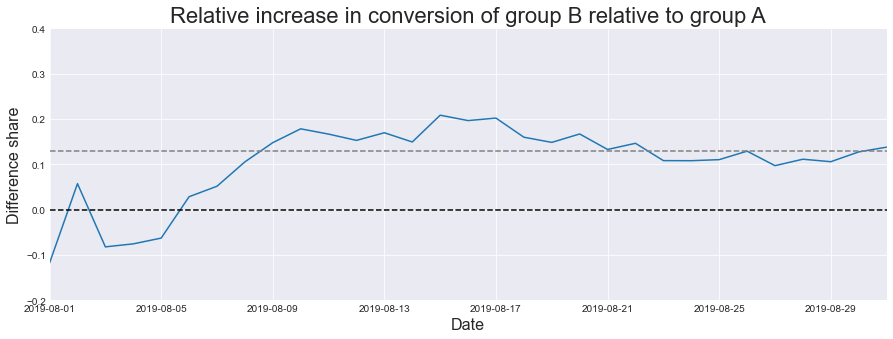

In [89]:
get_line_plot(title='Relative increase in conversion of group B relative to group A', 
              xlabel='Date', ylabel='Difference share', 
              x_series=merged_cumulative_conversions['date'],
              y_series=(merged_cumulative_conversions['conversion_B']/merged_cumulative_conversions['conversion_A']-1),
              axis_limits=[pd.to_datetime('2019-08-01'), pd.to_datetime('2019-08-31'), -0.2, 0.4], 
              axhline_values=[0, 0.13])

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Продолжать смысла нет, потому как вероятность того, что при продолжении теста конверсия в выборке B станет хуже конверсии в выборке A, стремиться к нулю.